# Redes Bayesianas Discretas: Aprendizaje Estructural
#### Master in Data Science - Machine Learning II
#### Santander Meteorology Group. Profesor: Mikel N. Legasa (mikel.legasa@unican.es)
#### 18 Mar 2020

La presente práctica pretende introducir el aprendizaje del Grafo Dirigido Acíclico (DAG) de una Red Bayesiana, utilizando para ello la librería `bnlearn` y con el ejemplo *survey* que utilizamos en la práctica anterior. 

En la práctica anterior asumimos un conocimiento experto del sistema de dependencias/independencias del dataset, y creamos la estructura acorde. En este contexto, la red bayesiana es utilizada como un sistema experto que formaliza nuestro conocimiento sobre un determinado campo (en este caso los usuarios de transportes).

Sin embargo, más frecuentemente los parámetros y el grafo de la red son aprendidos (estimados) de manera automática a partir de una muestra observada. 

En primer lugar cargamos el fichero con los datos de la encuesta. Están contenidos en un fichero “.txt”. También cargamos `bnlearn`:

In [1]:
library(bnlearn)
survey <- read.table("survey.txt", header = TRUE)
head(survey)


Attaching package: ‘bnlearn’

The following object is masked from ‘package:stats’:

    sigma



A,R,E,O,S,T
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
adult,big,high,emp,F,car
adult,small,uni,emp,M,car
adult,big,uni,emp,F,train
adult,big,high,emp,M,car
adult,big,high,emp,M,car
adult,small,high,emp,F,train


El aprendizaje estructural de la red es necesario en muchas ocasiones, por ejemplo cuando nos enfrentamos a sistemas complejos en los que el conocimiento experto puede fallar o simplemente no ser abarcable dada la complejidad de la red (sistemas biológicos, procesos metabólicos…). Tambien el aprendizaje automático de la estructura de la red puede ayudar a comprender mejor qué factores afectan y cuáles no a una determinada variable de interés, cuando este conocimiento no lo tenemos a priori …

Se trata no obstante de una labor compleja, debido fundamentalmente al gran número de posibles DAGs que potencialmente pueden probarse. En la práctica, existen algoritmos diseñados para este fin que pueden ser de gran utilidad, y que se encuentran implementados en el paquete bnlearn. Estos algoritmos se basan en dos tipos de criterios estadísticos: tests de independecia condicionada y network scores, y se basan en rastrear las posibles configuraciones del grafo que maximizan estos scores.

Los algoritmos de aprendizaje estrcutural implementados en bnlearn se muestran aquí: https://www.bnlearn.com. En la clase anterior exploramos brevemente al algoritmo PC, que implementa Inductive Causation restringiendo el conjunto $\bf S$.

En esta breve práctica trabajaremos solamente con los algoritmos basados en scores, centrándonos en el algoritmo hill-climbing, que ya hemos analizado en la clase teórica.

Para más detalles, se puede obtener ayuda específica y referencias sobre cada uno de ellos usando `help("score-based algorithms")` y `help("constraint-based algorithms")`.

### 1) Scores de Evaluación Global de la Red
Como hemos visto en la parte teórica, los scores globales, o network scores, se centran en el DAG en su conjunto en lugar de en nodos/arcos particulares a diferencia de los tests de probabilidades condicionadas que hemos visto en la anterior sección. Se trata de estadísticos que miden la bondad de ajuste del DAG a la estructura de dependencias implícita en los datos. Hay diversos scores, pero el más común es el criterio de información bayesiano (Bayesian Information Criterion o BIC), que se calcularía para nuestro modelo particular a través de la siguiente expresión:



\begin{aligned}
  BIC = log \hat P (A,S,E,O,R,T) - \frac{d}{2}log~n = \\
      [log \hat P(A) - \frac{d_{A}}{2}log~n] + [log \hat P(S) - \frac{d_{S}}{2}log~n] + \\ 
      [log \hat P(E|A,S) - \frac{d_{E}}{2}log~n] + [log \hat P(O|E) - \frac{d_{O}}{2}log~n] + \\
      [log \hat P(R|E) - \frac{d_{R}}{2}log~n] + [log \hat P(T|O,R) - \frac{d_{T}}{2}log~n],
  \end{aligned}

donde n es el tamaño de la muestra, d es el número de parámetros (en nuestro caso 21, como ya hemos visto) y $d_A, d_S, d_E, d_O, d_R$ y $d_T$, son el número de parámetros asociado a cada nodo. Otorga un score más alto cuanto mejor se ajusta el DAG a los datos.

Una vez tenemos una medida de cómo de *bueno* es nuestro DAG, se utiliza cualquier algoritmo de optimización buscando entre todos los DAG posibles. Recuérdese que esto es computacionalmente inviable, de modo que hay que recurrir a técnicas heurísticas de búsqueda.

Un algoritmo típico es, como ya hemos visto, el llamado hill climbing, que comienza con un DAG sin ningún arco y procede añadiendo, cambiando de sentido y quitando arcos sucesivamente reteniendo los cambios que maximizan el incremento del score en cada paso. Está implementado en `bnlearn`con la función `hc()` y, fijando el valor del argumento `debug = TRUE`, se obtiene por pantalla información detallada sobre el proceso de búsqueda hill climbing.

[1] "[R][E|R][T|R][A|E][O|E][S|E]"

Loading required namespace: Rgraphviz


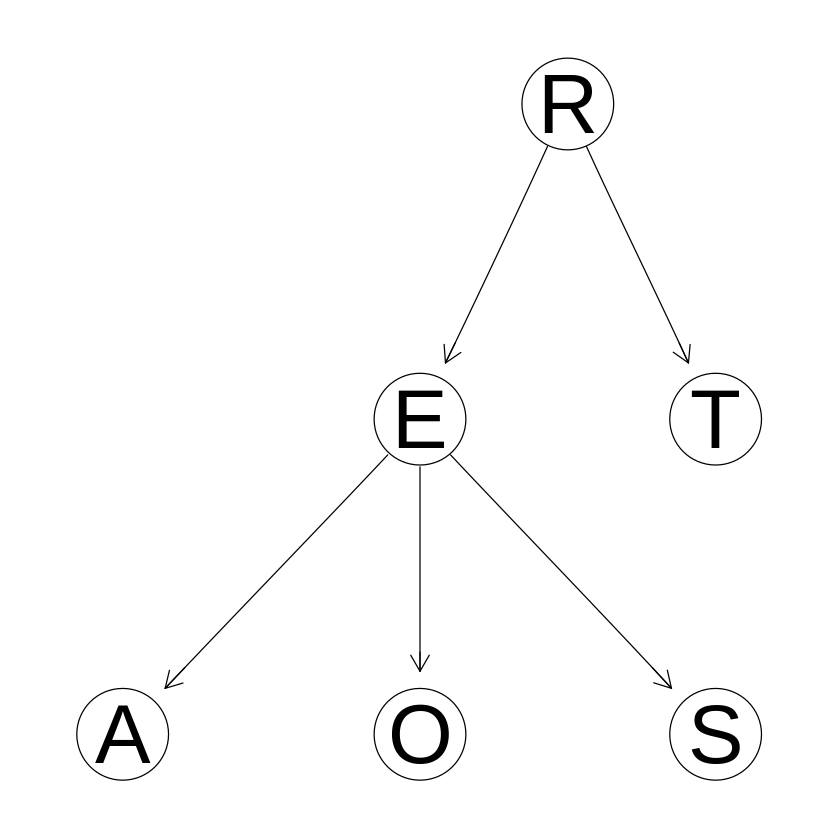

In [2]:
learned <- hc(survey)
modelstring(learned)
graphviz.plot(learned)

Para calcular el score utilizamos la función `score()`. Existen otros además del BIC.

In [3]:
bnlearn::score(learned, data = survey)

[1] -1998.432

Por defecto, la función calcula el BIC, aunque otros scores son posibles, como el Akaike Information Criterion (AIC) (`score = "aic"`) o el Log Likelihood (`score = "logLik"`). 

En realidad, `score()` utiliza un parámetro de penalización, `k`, que si no se establece equivale a `log(nrow(survey))*nparams(learned)/2`, y por tanto a la fórmula del BIC. El Log Likelihood equivale a `k = 0`, mientras que para el AIC la penalización se establece en `k = nparams(learned)`. Lo comprobamos:

In [4]:
bnlearn::score(learned, data = survey, type = "loglik") - 
   log(nrow(survey))*(nparams(learned, data = survey)/2)

[1] -1998.432

In [5]:
bnlearn::score(learned, data = survey, type = "loglik") - 
   log(nrow(survey))*(nparams(learned, data = survey)/2)

[1] -1998.432

In [6]:
bnlearn::score(learned, data = survey, type = "aic")

[1] -1966.823

In [7]:
bnlearn::score(learned, data = survey, type = "loglik") - 
   1*(nparams(learned, data = survey))

[1] -1966.823

Independientemente del score utilizado, podemos utilizar un score para evaluar cuál de dos grafos modela mejor los datos.

**Ejercicio 1** En la práctica anterior construimos un DAG a mano, utilizando conocimiento experto. Está guardado en el archivo *dag_experto.rda*. Cárgalo, contiene la variable `dag`.

- Si tenemos en cuenta el BIC, ¿Cuál de los dos grafos modeliza mejor los datos?

- Ahora calcula el Log Likelihood. Explica qué ocurre.

In [8]:
load("dag_experto.rda")
score(dag, data = survey, type = "loglik")
score(learned, data = survey, type = "loglik")
score(dag, data = survey, type = "bic")
score(learned, data = survey, type = "bic")

[1] -1947.433

[1] -1951.823

[1] -2012.687

[1] -1998.432

Teniendo en cuenta el BIC, el grafo mejor es el aprendido automáticamente. Sin embargo, el Log Likelihood de nuestro grafo es mejor.

Esto ocurre porque el Log Likelihood no incluye penalización por el número de parámetros. Si no existiese un término de penalización en el algoritmo a la hora de aprender un grafo el resultado sería el grafo completo, i.e. aquel que daría lugar a la factorización dada por la regla de la cadena.

Lo que ocurre es que siempre que se añade un arco nuevo a un modelo, este tendrá un Loglikelihood mayor o igual, en la inmensa mayoría de los casos mayor. Hay que tener en cuenta que, en la realidad, cuando se trabaja con un conjunto de datos, es imposible que se dé una dependencia o independencia "absoluta", sinó que habrá dependencias más fuertes y más débiles. 

Por eso, la red bayesiana descarta las independencias más débiles, pero aún así, esas dependencias están en el conjunto de datos, aunque sean muy bajas (ejemplo: Edad y Sexo sabemos que son independientes, pero la muestra del dataset podría mostrar una correlación de, por ejemplo, 0.05). Es por eso que añadir un arco siempre (salvo en el caso de independencia absoluta) añadirá Log Likelihood y la razón por la cual en el BIC está el parámetro de penalización.

Es el caso del presente ejercicio, tenemos un DAG que tiene un arco más, y por eso tiene más Log Likelihood. En la práctica, utilizando el BIC, vemos que según éste dicho arco no "compensa".

In [9]:
nparams(learned, data = survey)
nparams(dag, data = survey)

[1] 15

[1] 21



Puede comprobarse que aprender el grafo con el Log Likelihood da lugar al grafo completo, y que la factorización de este grafo es la de la regla de la cadena:

[1] "[A][R|A][T|A:R][S|A:R:T][O|A:R:S:T][E|A:R:O:S:T]"

[1] 143

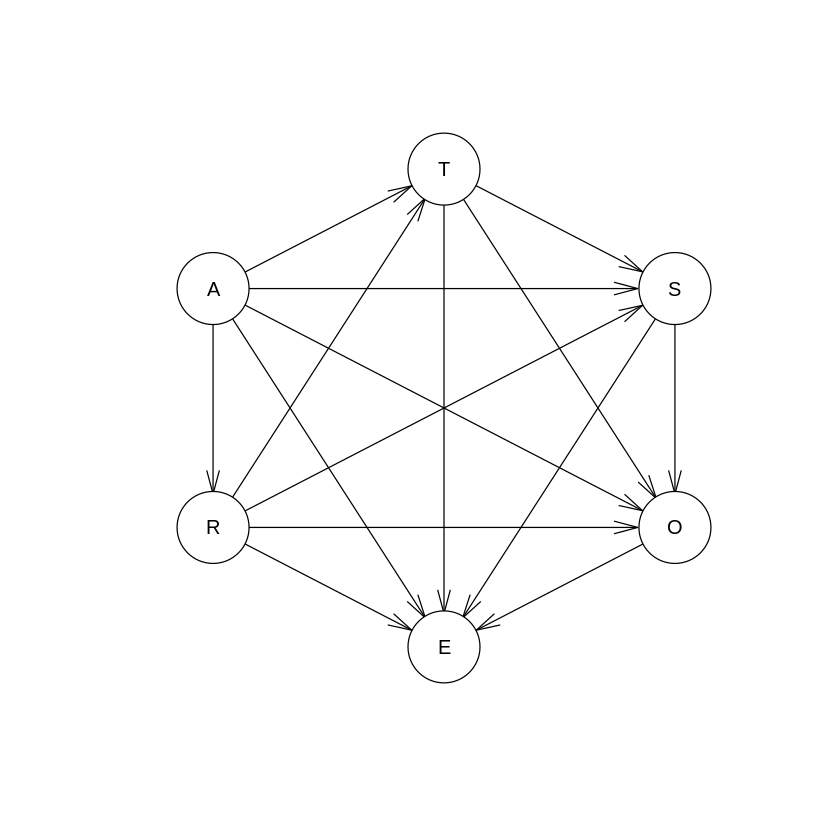

In [10]:
learned.loglik <- hc(survey, score = "loglik")
plot(learned.loglik)
modelstring(learned.loglik)
nparams(learned.loglik, survey)

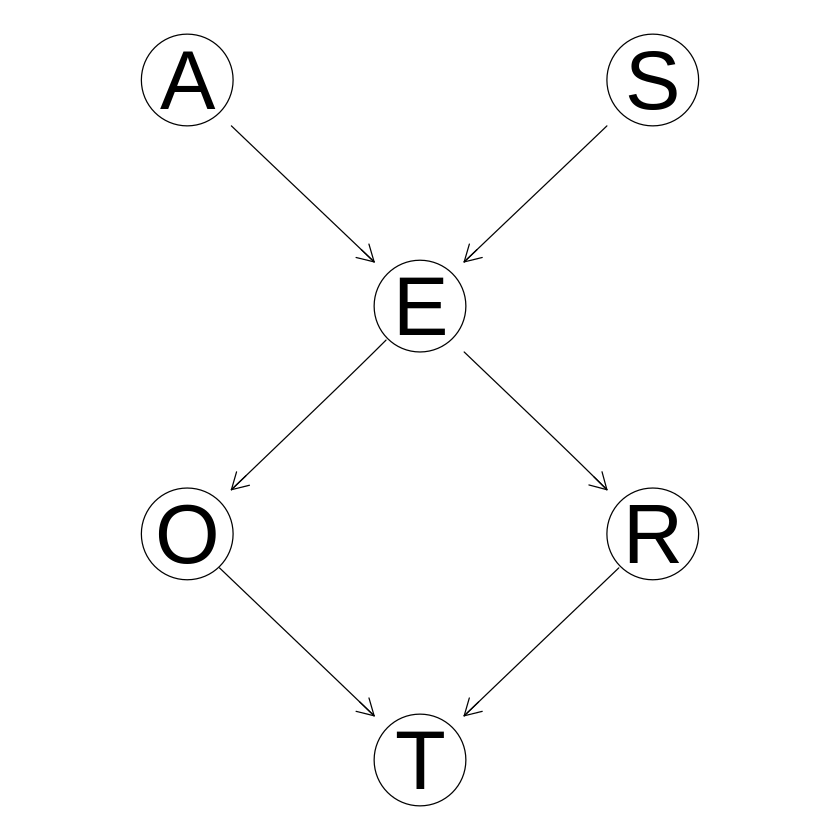

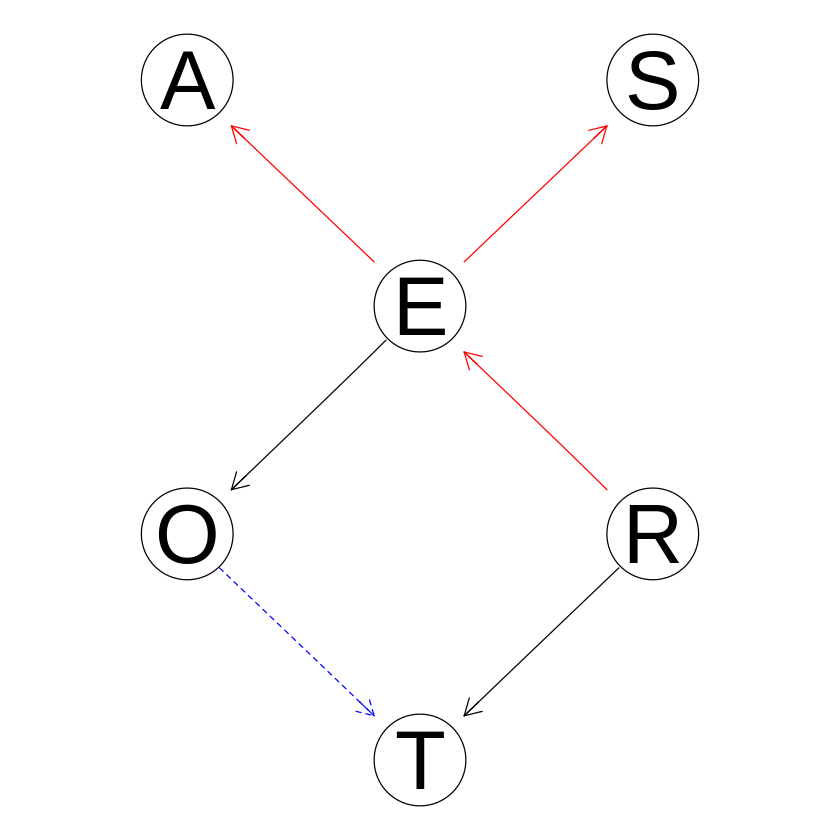

In [11]:
graphviz.compare(dag, learned)

Podemos ver cuál es la penalización `k` que ha empleado nuestro algoritmo imprimiendo los detalles de la variable, almacenado en `learned$learning$args$k`.

In [12]:
learned


  Bayesian network learned via Score-based methods

  model:
   [R][E|R][T|R][A|E][O|E][S|E] 
  nodes:                                 6 
  arcs:                                  5 
    undirected arcs:                     0 
    directed arcs:                       5 
  average markov blanket size:           1.67 
  average neighbourhood size:            1.67 
  average branching factor:              0.83 

  learning algorithm:                    Hill-Climbing 
  score:                                 BIC (disc.) 
  penalization coefficient:              3.107304 
  tests used in the learning procedure:  40 
  optimized:                             TRUE 


Vemos que el coeficiente de penalización es $k \approx 3.107 $. En efecto:

In [13]:
log(nrow(survey))/2

[1] 3.107304

### 2) Imponer restricciones al aprendizaje automático

Podemos imponer al algoritmo relaciones de dependencia que sabemos a priori que existen, de modo que estas se encuentren en el grafo final de forma obligatoria (por ejemplo, de acuerdo con el experto consultado, existe una influencia de la ocupación (O) sobre el transporte (T), que no queda reflejada en el grafo aprendido a partir de los datos). Del mismo modo, podemos descartar relaciones que pudieran aparecer y que en ese caso serían espúreas (por ejemplo, una relación entre E y S, que podemos conocer a priori que son independientes). Estas relaciones de dependencia/independencia conocidas de antemano pueden especificarse antes de lanzar el algoritmo, introduciéndolas a través de los argumentos whitelist/blacklist.

Podemos imponer al algoritmo relaciones de dependencia que sabemos a priori que existen, de modo que estas se encuentren en el grafo final de forma obligatoria (por ejemplo, de acuerdo con el experto consultado, existe una influencia de la ocupación (O) sobre el transporte (T), que no queda reflejada en el grafo aprendido a partir de los datos). Del mismo modo, podemos descartar relaciones que pudieran aparecer y que en ese caso serían espúreas (por ejemplo, una relación entre la edad (A) y el sexo (S), que como hemos visto son independientes). 

Estas relaciones de dependencia/independencia conocidas de antemano pueden especificarse antes de lanzar el algoritmo, introduciéndolas a través de los argumentos `whitelist` (para obligar a que esté presente un conjunto de arcos) y `blacklist` (para negar la posibilidad de que esté presente un conjunto de arcos). Estos argumentos son comunes a todos los algoritmos de `bnlearn`. La sintaxis es la misma que utilizábamos para establecer los arcos del DAG manualmente:

In [14]:
whitelist <- matrix(c("O", "T"),
                    ncol = 2,
                    dimnames = list(NULL, c("from", "to")))
blacklist <- matrix(c("A", "S", 
                      "S", "A"), 
                    ncol = 2, byrow = TRUE,
                    dimnames = list(NULL, c("from", "to")))
# Notar que prohibir una direccion no impide que el arco aparezca en la otra

learned2 <- hc(survey, whitelist = whitelist, blacklist = blacklist)
bnlearn::score(learned2, data = survey, type = "loglik")

[1] -1954.766

En este caso, el nuevo grafo obtiene un Log Likelihood más bajo. Como contraprestación, hemos asegurado que una serie de dependencias(independencias que sabemos positivamente que existen han quedado reflejadas en el grafo, aunque para caracterizar la distribución global sea mejor que no esté presente. 

Podemos verificar si la relación que hemos forzado en el DAG O $\rightarrow$ T  resulta significativa. Como ya sabemos, los algoritmos *constraint-based* utilizan test de independencia. Podemos aplicar uno de estos test para verificar si un arco está justificado incluirlo.

La función `arc.strength()` muestra los p-valores de los arcos presentes en un grafo obtenidos de realizar el test de hipótesis

$$H_{0}: A \ \perp_p B  $$
$$H_{1}: A \ \not \perp_p B $$

para cada par de arcos del DAG $A$ y $B$. De esta manera, un p-valor menor que un nivel de significación dado $\alpha$, por defecto $0.05$, implica que la hipótesis nula se rechaza, y que por tanto no son independientes dado el conjunto de nodos $\mathbf{S}$, asumiendo por tanto la dependencia.

Nótese que los algoritmos que hacen test de independencia (*constraint-based*) asumen dependencia si el p-valor es menor que un $\alpha$, por defecto $0.05$.

In [15]:
arc.strength(learned2, data = survey, criterion = "x2")

from,to,strength
<chr>,<chr>,<dbl>
O,T,0.4235333231
R,E,0.0005599201
E,S,0.0005877751
T,R,0.0004095347
E,A,0.0008689951


Hemos hecho un test $\chi^2$, utilizando `criterion = "x2`. Como vemos, para todos los arcos excepto para O $\rightarrow$ T el p-valor (columna `strength`) es menor que 0.001, de manera que se rechaza que sean independientes al $99.9\%$ de confianza. Para el primero la hipótesis de independencia no se rechaza, así que, según los datos, estos nodos son independientes. Esto es  consistente con la construcción del DAG que ha hecho el algoritmo hill-climbing.

Nótese, sin embargo, que los dos tipos de algoritmos pueden dar resultados muy distintos por su diferente manera de considerar el problema: los primeros trabajando *localmente*, buscando independencias entre pares de nodos; y los segundos trabajando con un score *global*, pretendiendo ajustar la distribución conjunta de los datos.

**Ejercicio 2)** `bnlearn` implementa la búsqueda Tabú como algoritmo de optimización (*score-based*, por tanto) para aprender la estructura del DAG, mediante la función `tabu()`. Ejecuta esta función y compara el DAG obtenido con los otros con los que hemos trabajado. ¿Es el mismo grafo? ¿Cuál dirías que captura mejor la JPD (Joint Probability Distribution) de los datos? 

Nota: Podría serte útil la función `bnlearn::graphviz.compare()`.

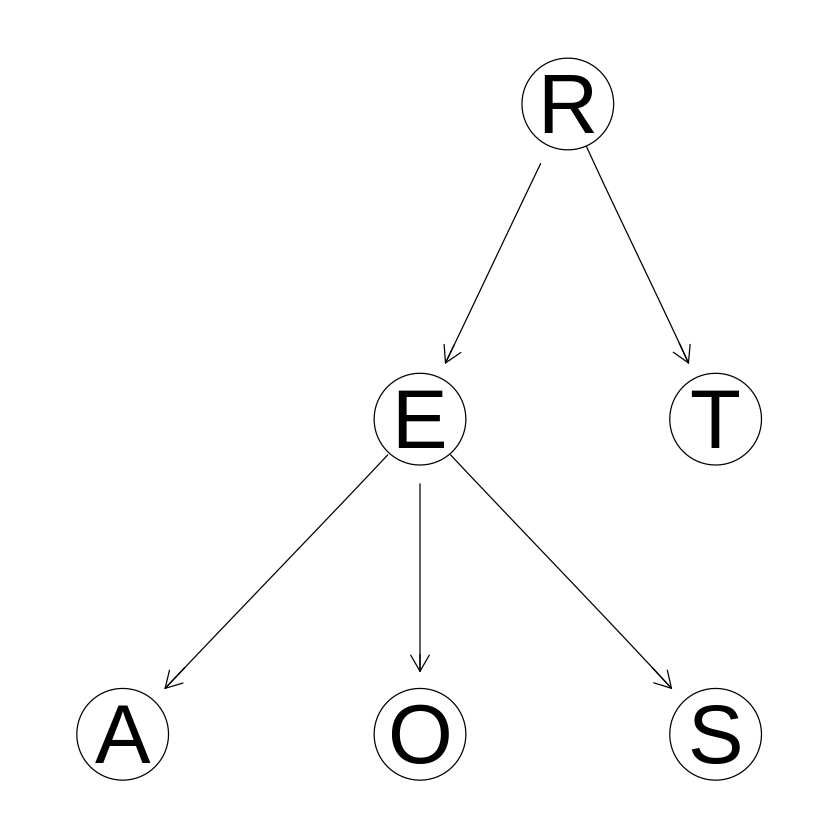

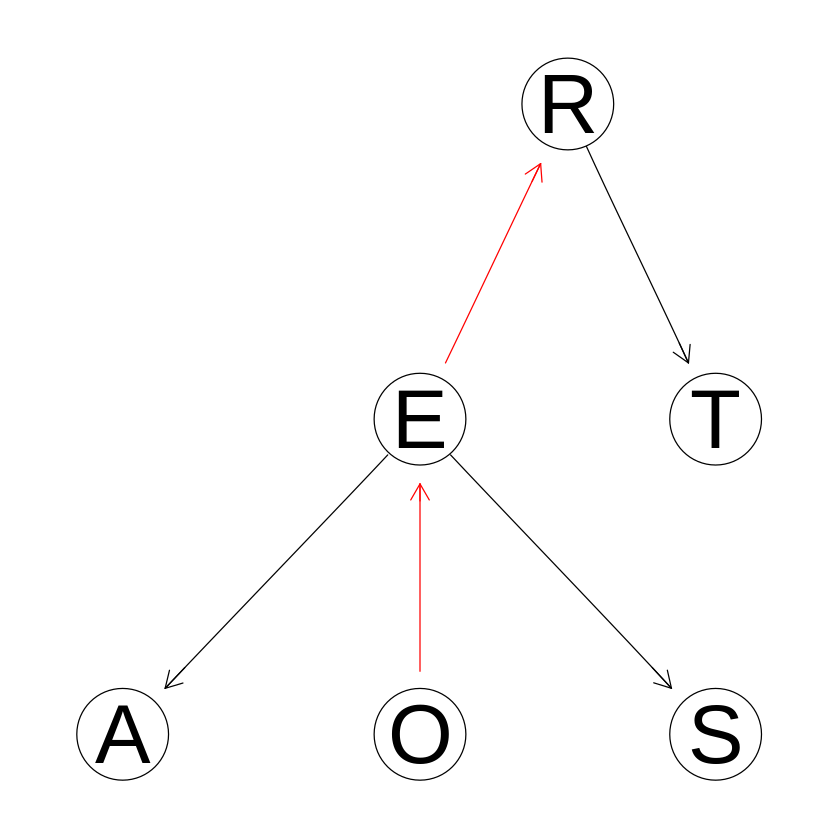

In [16]:
learned.hc <- hc(survey)
learned.tabu <- tabu(survey)
bnlearn::graphviz.compare(learned.hc, learned.tabu)

In [17]:
score(learned.tabu, type = "loglik", data = survey)
score(cextend(learned.hc), type = "loglik", data = survey)
modelstring(learned.tabu)
modelstring(cextend(learned.hc))

[1] -1951.823

[1] -1951.823

[1] "[O][E|O][A|E][R|E][S|E][T|R]"

[1] "[R][E|R][T|R][A|E][O|E][S|E]"

El escore es el mismo. No es de extrañar, ya que las factorizaciones son equivalentes:

[R][E|R][T|R][A|E][O|E][S|E] = [R][E|R][O|E] [A|E][S|E][T|R]

 [O][E|O][A|E][R|E][S|E][T|R] = [O][E|O][R|E] [A|E][S|E][T|R]

Y a su vez...
 [R][E|R][O|E] = [E,R][O|E] = [R|E][E][O|E] = [R|E][O,E] = [R|E][E|O][O]

También puede verse por d-separación. Los arcos O -> E -> R pueden intercambiarse por R -> E -> O y la estructura de independencias no cambia.

**Ejercicio 3)** Haz esto mismo para el algoritmo `pc.stable()`. Es decir, compara el grafo obtenido con este algoritmo con el grafo obtenido usando Hill-Climbing.

Recuerda que `pc.stable()` devuelve un Grafo Parcialmente Dirigido Acíclico. Para dirigir todos los arcos de este tipo de grafo puedes utilizar la función `cextend()`. Elegirá una dirección para los arcos que quedaron sin dirigir, y para los que no importa la dirección porque dan lugar al mismo modelo probabilístico.

Puedes probar también algún otro algoritmo de `bnlearn` y hacer alguna otra comparación. También puedes jugar con los argumentos `k` para Hill-Climbing y `alpha` y `max.sx` para `pc.stable()`. 

Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
“using BIC with a non-standard penalty k = 1.”

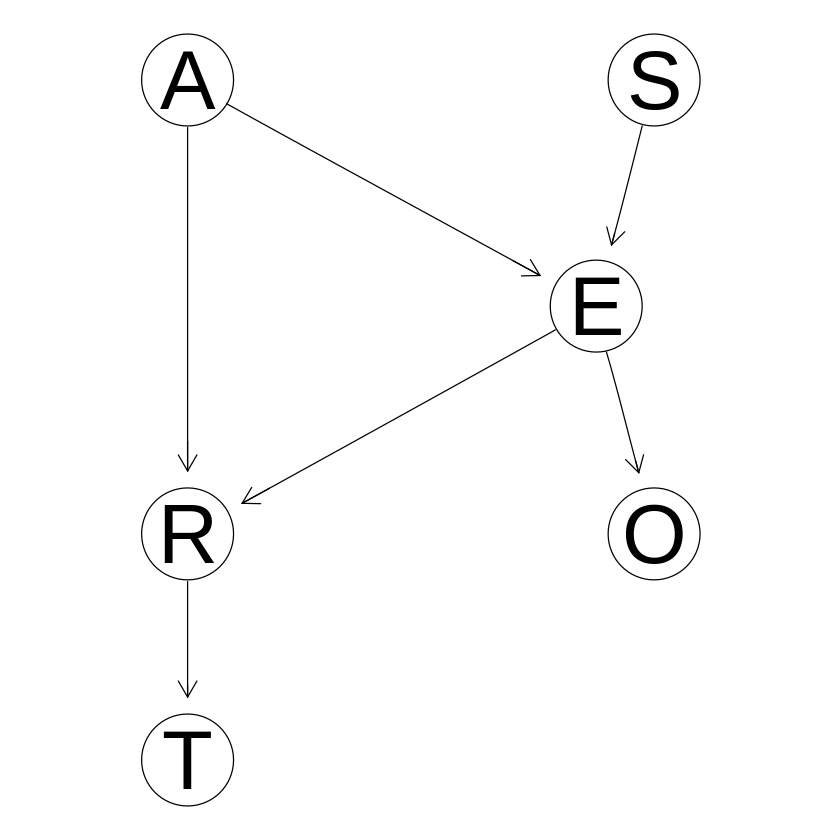

In [18]:
l.hc <- hc(survey, k = 1)
graphviz.plot(l.hc)

In [19]:
score(l.hc, type = "loglik", data = survey)
score(learned.hc, type = "loglik", data = survey)

[1] -1945.544

[1] -1951.823

Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
“vstructure E -> R <- T is not applicable, because one or both arcs are oriented in the opposite direction.”

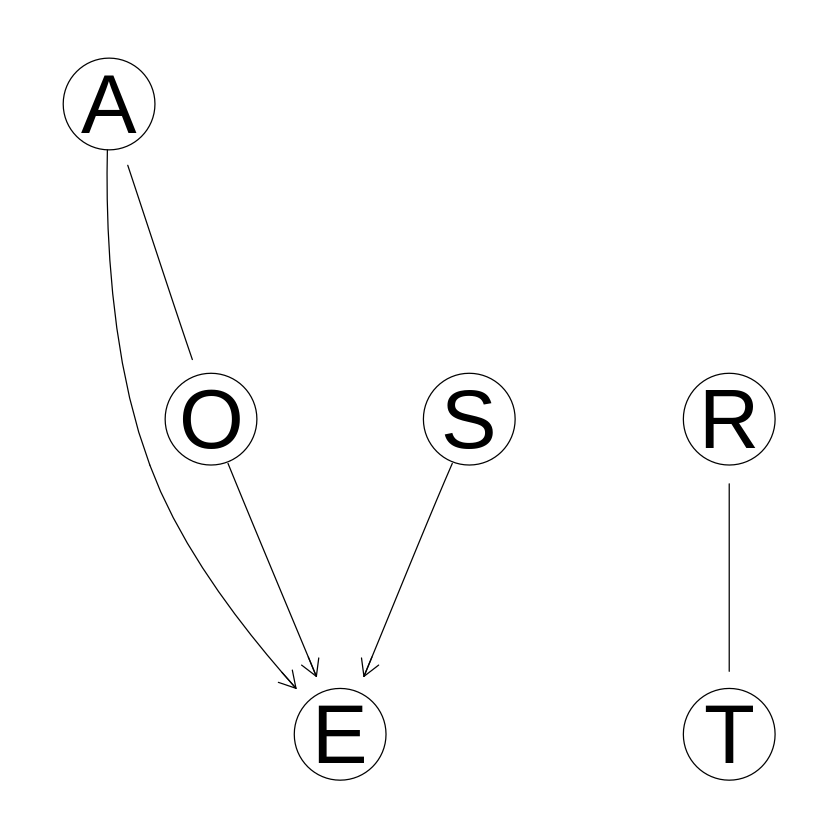

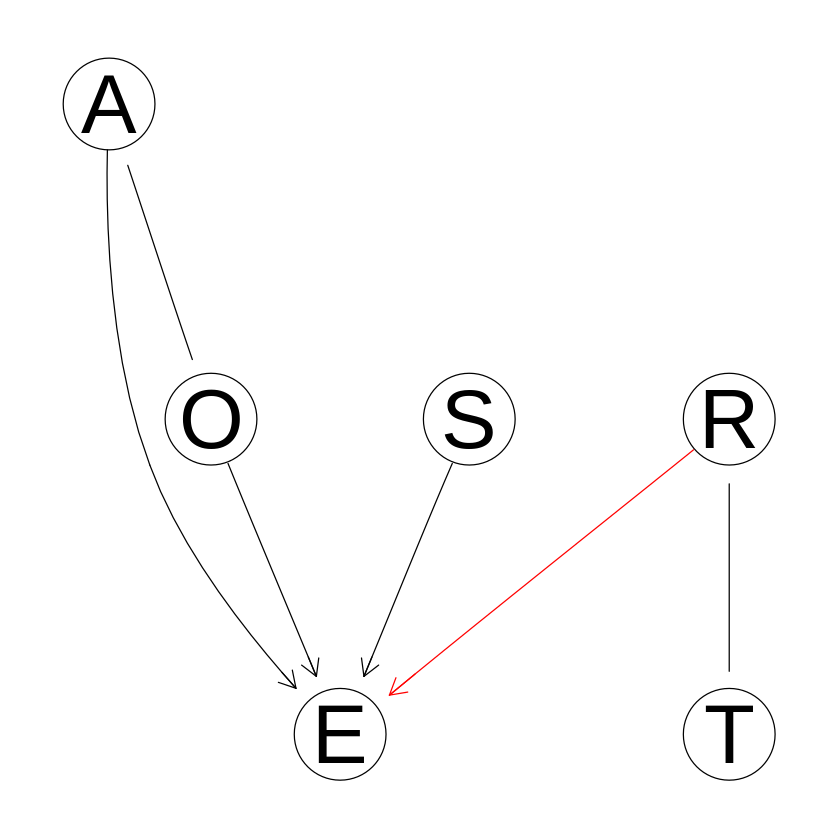

In [20]:
l.pc1 <- pc.stable(survey, max.sx = 5, alpha = 0.1)
l.pc2 <- pc.stable(survey, max.sx = 2, alpha = 0.1)
graphviz.compare(l.pc1, l.pc2)